# PIV on DE images

Velocimetry analysis is essential in the double emulsion experiment because:

1. it quantifies the bacterial activity (it's interesting to see if activity depends on droplet size)
2. it's an evaluation of the "steady-state" assumption: we can measure mean velocity at the beginning, in the middle and at the end of an experiment and compare the velocities.

Preliminary data shows that bacterial activity (mean velocity) increases with outer droplet size (OD20~40 data). Here, we do a thorough analysis on the whole data set. There are challenges on this analysis:

1. moving droplets: in some videos, the outer droplets move due to coalescence, evaporation and other reasons. Such motion affects PIV results significantly. Here we select the frames where outer droplet motion is negligible for the analysis.
2. change focus: in some videos, we change the focus to see inner droplets better. This leads to big error in PIV. We also review the video first and select appropriate frames for analysis. 
3. Masking: only the motions inside droplets are of interest. Here, we use the "fixed_mask_PIV" method.

In [17]:
from deLib import droplet_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from myImageLib import readdata
from pivLib import piv_data, read_piv
from skimage import io
import os
from IPython.display import clear_output
import ipywidgets as widgets
import matplotlib
%matplotlib widget
# matplotlib.use("nbagg")
import cv2

## 1 Set up images and parameters

In [112]:
folder = "/home/zhengyang/drives/Elements/"
date = "01182022"
n = 23
fps = 50
mpp = 0.16
nframe = 10
s = 0

# the following are inferred from above
img_folder = os.path.join(folder, date, "{:02d}".format(n), "raw")
mask_dir = os.path.join(folder, date, "mask", "{:02d}.tif".format(n))
lt = readdata(img_folder, "tif")
l = lt[s:s+nframe]
print("{0:d}/{1:d} frames loaded.".format(len(l), len(lt)))

# create droplet_image instance to call PIV method
di = droplet_image(l, fps, mpp)
di

10/6000 frames loaded.


length: 10, image size: (706, 690), fps: 50.0, mpp: 0.16

### 1.1 A preview tool with a slider
- To check if droplet or focus motion is significant

In [113]:
# load images and create frame number list
img_stack = {}
for num, i in l.iterrows():
    img_stack[int(i.Name)] = io.imread(i.Dir)
frame_numbers = l.Name.astype("int")

plt.ioff()
fig = plt.figure()
plt.ion()
im = plt.imshow(img_stack[frame_numbers.iloc[0]], cmap="gray")
def update(change):
    im.set_data(img_stack[change['new']])
    fig.canvas.draw_idle()
slider = widgets.IntSlider(value=frame_numbers.iloc[0], min=frame_numbers.iloc[0], max=frame_numbers.iloc[-1])
slider.observe(update, names='value')
widgets.VBox([slider, fig.canvas])

### 1.2 Test PIV window size

In [114]:
# make a substack to make test process shorter
small_stack_length = 10
###
di_small = droplet_image(l.iloc[:small_stack_length], fps, mpp) # only take first two frames
di_small

length: 10, image size: (706, 690), fps: 50.0, mpp: 0.16

In [115]:
# compute PIV at various window sizes
piv_winsize = {}
for winsize in range(20, 80, 10):
    overlap = winsize // 2
    mask = io.imread(mask_dir)
    mask2 = cv2.erode(mask, np.ones([winsize, winsize]), iterations=1)
    piv, params = di_small.fixed_mask_piv(winsize, overlap, mask2)
    piv_winsize[winsize] = piv

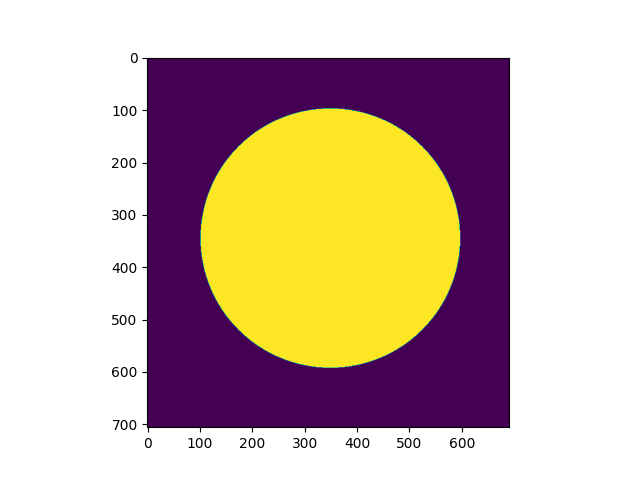

In [116]:
plt.figure()
plt.imshow(mask)

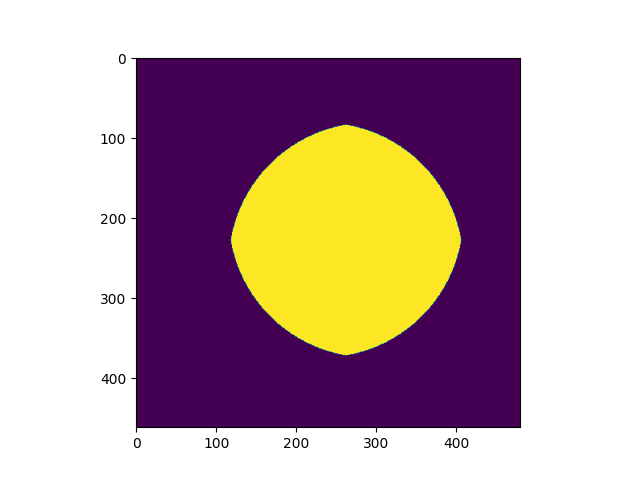

In [85]:
kernel = np.ones((60,60))
mask2 = cv2.erode(mask, kernel, iterations=1)
plt.figure()
plt.imshow(mask2)

#### 1.2.1 Mean velocity vs. window size

We first try different window sizes on the same image set and see if mean velocity depends strongly on the window size. 

In [8]:
def piv_mean_vel(piv):
    """Compute mean vel from dict PIV data."""
    s = 0
    count = 0
    for kw in piv:
        s += np.nanmean(piv[kw].u ** 2 + piv[kw].v ** 2) ** 0.5
        count += 1
    return s  / count

Text(0, 0.5, 'mean velocity (px/s)')

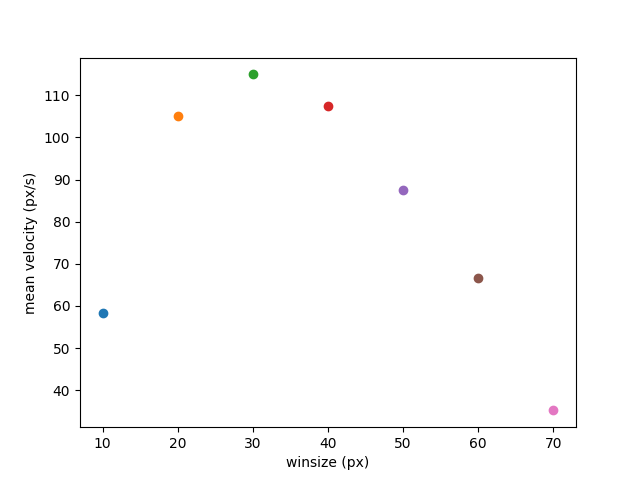

In [108]:
plt.figure()
for winsize in piv_winsize:
    piv = piv_winsize[winsize]
    plt.scatter(winsize, piv_mean_vel(piv))
plt.xlabel("winsize (px)")
plt.ylabel("mean velocity (px/s)")

#### 1.2.2 Visual inspection

Then we overlay the PIV results on images to double check the quality of PIV.

In [33]:
def piv_to_xyuv(pivData):
    """Convert piv dataframe to xyuv matrices."""
    row = len(pivData.y.drop_duplicates())
    col = len(pivData.x.drop_duplicates())
    X = np.array(pivData.x).reshape((row, col))
    Y = np.array(pivData.y).reshape((row, col))
    U = np.array(pivData.u).reshape((row, col))
    V = np.array(pivData.v).reshape((row, col))
    return X, Y, U, V

In [117]:
# visual inspection, check window size effect by slider animation
img = io.imread(di_small.sequence.iloc[0, 1])
winsize = list(piv_winsize.keys())[0]
piv = piv_winsize[winsize]
piv_item = piv[list(piv.keys())[0]]

plt.ioff()
fig = plt.figure(dpi=100)
plt.ion()

plt.imshow(img, cmap="gray")
x, y, u, v = piv_to_xyuv(piv_item)
plt.quiver(x, y, u, v, color="yellow")

def update(change):
    plt.clf()
    plt.imshow(img, cmap="gray")
    winsize = change['new']
    piv = piv_winsize[winsize]
    piv_item = piv[list(piv.keys())[0]]
    x, y, u, v = piv_to_xyuv(piv_item)
    plt.quiver(x, y, u, v, color="yellow")
    fig.canvas.draw_idle()
    
drop = widgets.Dropdown(
            options=piv_winsize.keys(),
            value=list(piv_winsize.keys())[0],
            description='Window size',
            disabled=False)
drop.observe(update, names='value')
widgets.HBox([drop, fig.canvas])

In [118]:
# visual inspection: animation
# choose PIV data
winsize = 20
pivData = piv_winsize[winsize]
keys = list(pivData.keys())


plt.ioff()
fig = plt.figure(dpi=100)
plt.ion()
im = plt.imshow(img_stack[frame_numbers.iloc[0]], cmap="gray")
x, y, u, v = piv_to_xyuv(pivData[keys[0]])
uv = plt.quiver(x, y, u, v, color="yellow")
def update(change):
    frame = change['new']
    im.set_data(img_stack[frame])
    x, y, u, v = piv_to_xyuv(pivData["{0:05d}-{1:05d}".format(frame, frame+1)])
    uv.set_UVC(u, v)
    fig.canvas.draw_idle()
slider = widgets.IntSlider(value=frame_numbers.iloc[0], min=frame_numbers.iloc[0], max=frame_numbers.iloc[-1])
slider.observe(update, names='value')
widgets.HBox([slider, fig.canvas])

### 1.3 Run PIV at the determined window size

Sample 3 segments from the beginning, the middle and the end of the image sequence. 

In [250]:
winsize = 20
length = 50
start = 500

In [251]:
vm_list = []
for segment in [lt[start: start+length], lt[len(lt)//2:len(lt)//2+length], lt[-length:]]:
    di = droplet_image(segment, fps, mpp) # only take first two frames
    piv, params = di.fixed_mask_piv(winsize, winsize//2, mask_dir)
    vm_list.append(piv_mean_vel(piv)*mpp)
print(vm_list)

[2.8488429524873733, 2.338512001523504, 2.6961715540378615]
